In [48]:
import numpy as np
import networkx as nx
from scipy.optimize import minimize
import scipy.optimize as opt
from collections import defaultdict
import matplotlib.pyplot as plt
import random

from qiskit import *
from qiskit import Aer
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

##### 构造GHZ线路

In [32]:
def get_GHZ_circuit(p, graph, params):
    # nodew = nx.get_node_attributes(graph, 'weight')
    edges_weight = nx.get_edge_attributes(graph, 'weight')

    gamma_list, beta_list = params[: p], params[p:]
    circ_qreg = QuantumRegister(len(graph), 'q')
    circ = QuantumCircuit(circ_qreg)

    pivot = len(graph) // 2

    for k in range(p):
        for nd in graph.nodes:
            if k == 0:
                circ.h(nd)

        for edge in graph.edges:
                u, v = edge[0], edge[1]
                if u == v:
                    continue
                circ.rzz(2 * gamma_list[k] * edges_weight[edge[0], edge[1]], u, v)  #

        circ.barrier()
        for nd in graph.nodes:
            if nd != pivot:
                circ.rx(2 * beta_list[k], nd)
                
        circ.barrier()

    # circ.measure_all()
    return circ

##### 图分解模块：传入 graph,P ，得到子图集 element_to_graph:{node/edge: graph}

In [33]:
def generate_weighted_graph(nodes, edges, weight_range=10):
    g = nx.Graph()
    if isinstance(nodes, list) and isinstance(edges, list):
        for v in nodes:
            w = np.random.choice(range(weight_range))
            g.add_node(v, weight=w)

        for e in edges:
            w = np.random.choice(range(weight_range))
            g.add_edge(e[0], e[1], weight=w)
    else:
        for item in nodes:
            g.add_node(item[0], weight=item[1])

        for item in edges:
            g.add_edge(item[0], item[1], weight=item[2])
    return g


def get_graph_weights(graph):
    nodew = nx.get_node_attributes(graph, 'weight')
    edw = nx.get_edge_attributes(graph, 'weight')
    edgew = edw.copy()
    for key, val in edw.items():
        edgew[(key[1], key[0])] = val

    return nodew, edgew
    

def generate_subgraph(graph, dtype: str, p):
    if dtype not in ["node", "edge"]:
        print("Error: wrong dtype, dtype should be node or edge")
        return None

    nodes_weight, edges_weight = get_graph_weights(graph)

    subg_dict = defaultdict(list)
    if dtype == 'node':
        for node in graph.nodes:
            node_set = {(node, nodes_weight[node])}
            edge_set = set()
            for i in range(p):
                new_nodes = {(nd2, nodes_weight[nd2]) for nd1 in node_set for nd2 in graph[nd1[0]]}
                new_edges = {(nd1[0], nd2, edges_weight[nd1[0], nd2]) for nd1 in node_set for nd2 in graph[nd1[0]]}
                node_set |= new_nodes
                edge_set |= new_edges

            subg = generate_weighted_graph(node_set, edge_set)
            subg_dict[node] = subg
    else:
        for edge in graph.edges:
            node_set = {(edge[0], nodes_weight[edge[0]]), (edge[1], nodes_weight[edge[1]])}
            edge_set = {(edge[0], edge[1], edges_weight[edge[0], edge[1]])}

            for i in range(p):
                new_nodes = {(nd2, nodes_weight[nd2]) for nd1 in node_set for nd2 in graph[nd1[0]]}
                new_edges = {(nd1[0], nd2, edges_weight[nd1[0], nd2]) for nd1 in node_set for nd2 in
                                graph.adj[nd1[0]]}
                node_set |= new_nodes
                edge_set |= new_edges

            subg = generate_weighted_graph(node_set, edge_set)
            subg_dict[edge] = subg
    return subg_dict


def graph_decomposition(graph, p):
    if p <= 0:
        warnings.warn(" the argument of p should be >= 1 in qaoa problem, "
                        "so p would be set to the default value at 1")
        p = 1

    subg_node = generate_subgraph(graph, "node", p)
    subg_edge = generate_subgraph(graph, "edge", p)
    element_to_graph = {}
    for k, v in subg_node.items():
        element_to_graph[k] = v

    for k, v in subg_edge.items():
        element_to_graph[k] = v
    return element_to_graph

##### QAOA 中计算期望的方式 $<phi| op |phi>$

In [34]:
from qiskit.aqua.operators import X, Y, Z, I

def get_operator(element, qubit_num):
    op = 1
    for i in range(qubit_num):
        if i in list(element):
            op = np.kron(Z.to_matrix(), op)
        else:
            op = np.kron(I.to_matrix(), op)
    return op

def get_expectation(element_graph, p):

    original_e, graph = element_graph
    op = get_operator(original_e, len(graph))
    circ = get_GHZ_circuit(p, graph, params)
    # print(op)
    # circ.draw(output='mpl', interactive=True)
    circ.save_statevector()

    sim = Aer.get_backend('qasm_simulator')  
    result = sim.run(circ, seed_simulator=43, nshots=1024).result()
    out_state = result.get_statevector()
    exp_res = np.matmul(np.matmul(out_state.conj().T, op), out_state).real

    ndw = nx.get_node_attributes(graph, 'weight')
    edw = nx.get_edge_attributes(graph, 'weight')
    if isinstance(original_e, int):
        weight = ndw[original_e]
    else:
        weight = edw[original_e]

    return weight, exp_res

def expectation_calculation(element_to_graph, p):
    res = 0
    # st = time.time()
    for item in element_to_graph.items():
        w_i, exp_i = get_expectation(item, p)
        res += w_i * exp_i  #
    # ed = time.time()
    # print("exp one cost:", ed - st)
    print("Total expectation of original graph is: ", res)
    return res

##### 从量子态分布中累加计算期望

In [35]:
def get_expectation_statistics(circ, graph):
    backend = Aer.get_backend('qasm_simulator')
    counts = backend.run(circ, seed_simulator=10, nshots=1024).result().get_counts()

    def Ising_obj(x, G):
        obj = 0
        for i, j in G.edges():
            if x[i] == x[j]:
                obj -= 1
            else:
                obj += 1
        return obj

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = Ising_obj(bitstring, graph)
        avg += obj * count
        sum_count += count
    exp_res = avg / sum_count

    return exp_res

##### 将最优参数带入不分解的量子线路得到每种态的分布并作图

In [36]:
def get_result_counts(p, params, graph):  # 直接将最优参数值带入整个大电路中运行qubit将只能到18

    params = params.flatten()
    circ = get_GHZ_circuit(p, graph, params)
    circ.measure_all()   # if use sample method, can't use measure
    circ.draw(output='mpl', interactive=True)

    sim = Aer.get_backend('qasm_simulator')
    transpiled_qc = transpile(circ, sim)
    job_sim = sim.run(transpiled_qc, shots=102400)
    hist = job_sim.result().get_counts(transpiled_qc)

    for key, val in hist.items():
        print("%s has %s" % (key, str(val)))

    from qiskit.visualization import plot_histogram
    plot_histogram(hist)
    plt.show()
    return hist

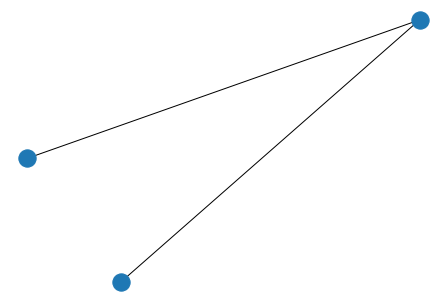

In [37]:
p = 1
node_num = 3

g = nx.Graph()
g.add_node(0, weight=0)
for i in range(1, node_num):
    g.add_node(i, weight=0)
    g.add_edge(i - 1, i, weight=-1)

nx.draw(g)

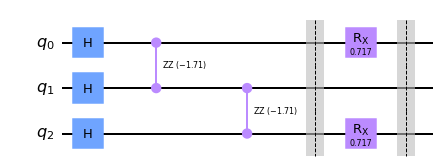

In [41]:
params = [random.random() for i in range(2*p)]
circ_g = get_GHZ_circuit(p, g, params)
circ_g.draw(output='mpl', interactive=True)

##### 两种方式分别只计算一次期望的结果比较

In [42]:
circ_g.measure_all()
backend = Aer.get_backend('qasm_simulator')
counts = backend.run(circ_g, seed_simulator=10, nshots=1024).result().get_counts()

def Ising_obj(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] == x[j]:
            obj -= 1
        else:
            obj += 1
    return obj

avg = 0
sum_count = 0
for bitstring, count in counts.items():
    obj = Ising_obj(bitstring, g)
    avg += obj * count
    sum_count += count
res_state = avg / sum_count
print(res_state)

1.283203125


In [43]:
res_exp = 0.0

for eg in g.edges:
    elem = (eg, g)
    w, exp = get_expectation(elem, p)
    res_exp += w * exp
print(res_exp)

1.3023522292784955


##### 两种期望计算方式分别优化得到期望值比较

In [ ]:
p = 30
node_num = 7

g = nx.Graph()
g.add_node(0, weight=0)
for i in range(1, node_num):
    g.add_node(i, weight=0)
    g.add_edge(i - 1, i, weight=-1)

# nx.draw(g)
    
params = [random.random() for i in range(2*p)]
circ_g = get_GHZ_circuit(p, g, params)
# circ_g.draw(output='mpl', interactive=True)

In [ ]:
def get_expectation_statistics(params, p, graph):
    circ = get_GHZ_circuit(p, g, params)
    circ.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    counts = backend.run(circ, seed_simulator=43, nshots=1024).result().get_counts()

    def Ising_obj(x, G):
        obj = 0
        for i, j in G.edges():
            if x[i] == x[j]:
                obj -= 1
            else:
                obj += 1
        return obj

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = Ising_obj(bitstring, graph)
        avg += obj * count
        sum_count += count
    exp_res = avg / sum_count
    
    print("expectation calculated by statistics is:", exp_res)
    return exp_res

res_stc = minimize(get_expectation_statistics,
                         x0=np.array(params),
                         args=(p, g),
                         method='COBYLA',
                         jac=opt.rosen_der)
# res_stc = get_expectation_statistics(circ_g, g)
print("expectation calculated by statistics is: ", res_stc)  # 1.650390625

In [ ]:


res_stc = minimize(get_expectation_statistics,
                         x0=np.array(params),
                         args=(p, g),
                         method='COBYLA',
                         jac=opt.rosen_der)

print("expectation calculated by statevector is: ", res_sta)



res_stc = minimize(get_expectation_statistics,
                         x0=np.array(params),
                         args=(p, g),
                         method='COBYLA',
                         jac=opt.rosen_der)

print("expectation calculated by statevector is: ", res_sta)

In [57]:
p = 30
node_num = 7

g = nx.Graph()
g.add_node(0, weight=0)
for i in range(1, node_num):
    g.add_node(i, weight=0)
    g.add_edge(i - 1, i, weight=-1)

# nx.draw(g)
    
params = [random.random() for i in range(2*p)]
circ_g = get_GHZ_circuit(p, g, params)
# circ_g.draw(output='mpl', interactive=True)

In [58]:
def get_expectation_statistics(params, p, graph):
    circ = get_GHZ_circuit(p, g, params)
    circ.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    counts = backend.run(circ, seed_simulator=43, nshots=1024).result().get_counts()

    def Ising_obj(x, G):
        obj = 0
        for i, j in G.edges():
            if x[i] == x[j]:
                obj -= 1
            else:
                obj += 1
        return obj

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = Ising_obj(bitstring, graph)
        avg += obj * count
        sum_count += count
    exp_res = avg / sum_count
    
    print("expectation calculated by statistics is:", exp_res)
    return exp_res

res_stc = minimize(get_expectation_statistics,
                         x0=np.array(params),
                         args=(p, g),
                         method='COBYLA',
                         jac=opt.rosen_der)
# res_stc = get_expectation_statistics(circ_g, g)
print("expectation calculated by statistics is: ", res_stc)  # 1.650390625

expectation calculated by statistics is: 2.6796875
expectation calculated by statistics is: 0.5078125
expectation calculated by statistics is: -1.611328125
expectation calculated by statistics is: -1.201171875
expectation calculated by statistics is: -0.90625
expectation calculated by statistics is: -1.396484375
expectation calculated by statistics is: -1.39453125
expectation calculated by statistics is: 1.734375
expectation calculated by statistics is: 1.7421875
expectation calculated by statistics is: -0.7734375
expectation calculated by statistics is: 1.228515625
expectation calculated by statistics is: 0.845703125
expectation calculated by statistics is: 1.53125
expectation calculated by statistics is: 1.201171875
expectation calculated by statistics is: -0.3203125
expectation calculated by statistics is: -0.75
expectation calculated by statistics is: -0.810546875
expectation calculated by statistics is: 0.71484375
expectation calculated by statistics is: -0.86328125
expectation ca

In [ ]:


res_stc = minimize(get_expectation_statistics,
                         x0=np.array(params),
                         args=(p, g),
                         method='COBYLA',
                         jac=opt.rosen_der)

print("expectation calculated by statevector is: ", res_sta)